We first import the necessary libraries and fetch the dataset. We then split the data into training and testing sets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split

# fetch dataset
phishing_websites = fetch_ucirepo(id=327)

# data (as pandas dataframes)
X = phishing_websites.data.features
y = phishing_websites.data.targets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7738, 30) (3317, 30) (7738, 1) (3317, 1)


We then train a decision tree classifier and visualize the tree.

We first train a decision tree classifier with a maximum depth of 3 and visualize the tree and calculate the accuracy of the prediction.

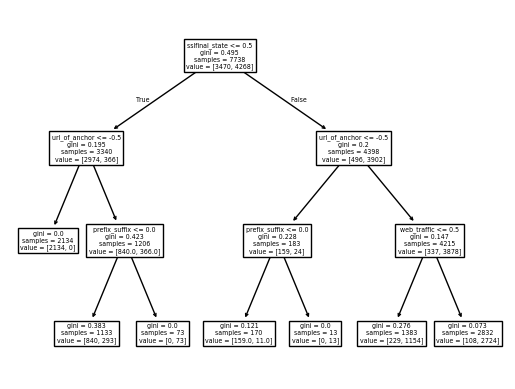

[[-1]
 [-1]
 [-1]
 ...
 [ 1]
 [ 1]
 [ 1]]
[-1 -1 -1 ...  1  1  1]


0.9170937594211637

In [2]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree

model_pruned = DecisionTreeClassifier(random_state=42, max_depth=3)
model_pruned.fit(X_train, y_train)

plot_tree(model_pruned, feature_names=X_train.keys())
plt.show()

print(y_test.values)
prediction_pruned = model_pruned.predict(X_test)
print(prediction_pruned)

accuracy_score(y_test, prediction_pruned)

We then train a decision tree classifier with a cost complexity pruning alpha of 0.012 and visualize the tree and calculate the accuracy of the prediction.

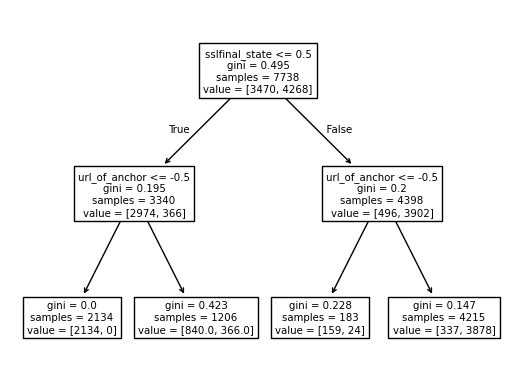

[[-1]
 [-1]
 [-1]
 ...
 [ 1]
 [ 1]
 [ 1]]
[-1 -1 -1 ...  1  1  1]


0.9068435333132349

In [3]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

model = DecisionTreeClassifier(random_state=42, ccp_alpha=0.012)
model.fit(X_train, y_train)

plot_tree(model, feature_names=X_train.keys())
plt.show()

print(y_test.values)
prediction = model.predict(X_test)
print(prediction)

accuracy_score(y_test, prediction)


From the two different decision tree classifiers, we can see that the first classifier with a maximum depth of 3 has an accuracy of 0.9116, while the second classifier with a cost complexity pruning alpha of 0.012 has an accuracy of 0.9068. The two classifiers have similar accuracy, but the second classifier has a more complex tree structure.

We will use the second classifier with a cost complexity pruning alpha of 0.012 for further analysis.

### Written instriuctions:

To find out if a site is a phishing site, follow these steps:
- If the sslfinal_state of the site is less than or equal to 0.5
    - And if the url_of_anchor is less than or equal to -0.5, then <b> it is a legitimate site </b>
    - Otherwise, if the utl_of_anchor is more than -0.5, then with a <b> 58% certainty it is a legitimate site </b>
- If the ssl-final_State of the site is more than 0.5
    - And if the url_of_anchor is less than or equal to -0.5, then with a <b> 78% certainty it is a legitimate site </b>
    - Otherwise, if the utl_of_anchor is more than -0.5, then with a <b> 86% certainty it is a phishing site </b>

# Random Forest:

We use GridSearchCV from sklearn to find good hyperparameters.

GridSearchCV goes through all possible permutations of given parameters and finds the model with the highest accuracy. This can be changed with the <i> scoring </i> parameter.

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Create a random forest model, we tune the hyperparameters using GridSearchCV
param_grid = {
    'max_depth': [6, 12],
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_samples': [0.5, 0.7, 0.9],
    'min_samples_leaf': [100, 200],
    'ccp_alpha': [0.01, 0.1, 0.3]
}
rf = RandomForestClassifier(random_state=42)

y_train_raveled = y_train.values.ravel()
y_test_raveled = y_test.values.ravel()

from sklearn.model_selection import GridSearchCV
gridSearch = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
gridSearch.fit(X_train, y_train_raveled)

print(f"Best parameters: {gridSearch.best_params_}")
print(f"Best score: {gridSearch.best_score_}")

best_rf = gridSearch.best_estimator_
best_rf.fit(X_train, y_train_raveled)

# Predict using the random forest model
rf_predictions = best_rf.predict(X_test)

# Calculate the accuracy
rf_accuracy = accuracy_score(y_test_raveled, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")


Fitting 3 folds for each of 144 candidates, totalling 432 fits


c:\Users\Administrator\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'ccp_alpha': 0.01, 'max_depth': 6, 'max_features': 'log2', 'max_samples': 0.9, 'min_samples_leaf': 100, 'n_estimators': 100}
Best score: 0.922589880700109
Random Forest Accuracy: 0.9315646668676515


Let's evaluate our random forest

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

# Display the confusion matrix and the classification report using the best random forest model
Y_pred = best_rf.predict(X_test)
print(f'Confusion matrix:\n{confusion_matrix(y_test, Y_pred)}')
print(classification_report(y_test, Y_pred))

# Display the feature importances for features used in the random forest
feature_importances = best_rf.feature_importances_

# Print the feature importances sorted by importance. Print only 5 most important features, rounded to 4 decimal places
print("Feature importances:")
for idx in np.argsort(feature_importances)[::-1][:5]:
    print(f"{X_train.columns[idx]:<20}: {feature_importances[idx]:.4f}")



Confusion matrix:
[[1268  160]
 [  67 1822]]
              precision    recall  f1-score   support

          -1       0.95      0.89      0.92      1428
           1       0.92      0.96      0.94      1889

    accuracy                           0.93      3317
   macro avg       0.93      0.93      0.93      3317
weighted avg       0.93      0.93      0.93      3317

Feature importances:
sslfinal_state      : 0.3368
url_of_anchor       : 0.3228
having_sub_domain   : 0.0869
web_traffic         : 0.0831
prefix_suffix       : 0.0686


From this we can say that our model has around 93% accuracy and recall, with slightly better performance detecting actual malicious sites, which is good.

The feature importances indicate that sslfinal_state and url_of_anchor are the most influential features in the model's predictions.

Overall, the model performs well.